<a href="https://colab.research.google.com/github/gj0210/CMP7239/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ==============================================================================
# --- Import Necessary Libraries ---
# ==============================================================================

import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Load and Prepare the Dataset ---
# ==============================================================================

# Load the dataset from the uploaded CSV file
try:
    df = pd.read_csv('Spam Detection (2).csv')
except FileNotFoundError:
    # The file name in the error message "Error: The file 'Spam Detection (2).csv' was not found." seems to be a placeholder/typo from the original notebook
    # Based on the available files, the correct file is likely 'Cybersecurity Intrusion Detection(3).csv'
    try:
        df = pd.read_csv('Cybersecurity Intrusion Detection(3).csv')
    except FileNotFoundError:
        print("Error: The file 'Cybersecurity Intrusion Detection(3).csv' was not found. Please ensure it is in the same directory.")
        exit()


# Print the first few rows to understand the data structure
print("--- Initial Dataset Head ---")
print(df.head())
print("\n--- Dataset Info ---")
print(df.info())

# Separate features (X) and target variable (y)
# The 'attack_detected' column is our target. All others are features.
X = df.drop(['attack_detected', 'session_id'], axis=1) # Drop session_id as well
y = df['attack_detected']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = SimpleImputer(strategy='mean') # Impute missing numerical values
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# ==============================================================================
# --- Exploratory Data Analysis (EDA) - Class Distribution ---
# ==============================================================================

print("\n--- Class Distribution ---")
print(y.value_counts())

# ==============================================================================
# --- Data Splitting ---
# ==============================================================================

# Split the data into training and testing sets (80% train, 20% test)
# We use stratify=y to ensure the train and test sets have the same proportion of attack_detected/non-attack_detected.
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nOriginal dataset size: {len(df)}")
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# ==============================================================================
# --- Model Implementation and Training ---
# ==============================================================================

# Dictionary to hold the models and their configurations
# We're using MultinomialNB as it's well-suited for count/frequency data.
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(solver='liblinear', C=1.0, random_state=42),
    'Gradient Boosting': LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n--- Training {name} Model ---")
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = (time.time() - start_time) * 1000 # Convert to milliseconds

    # Store results
    results[name] = {
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Training Time (s)': training_time,
        'Prediction Time (ms)': prediction_time,
    }

# ==============================================================================
# --- Results and Evaluation ---
# ==============================================================================

print("\n" + "="*50)
print("             Final Model Performance Summary")
print("="*50)

# Print performance metrics table
print("\n--- Performance Metrics Table ---")
performance_table = pd.DataFrame({
    'Algorithm': models.keys(),
    'Precision': [results[name]['Precision'] for name in models],
    'Recall': [results[name]['Recall'] for name in models],
    'F1-Score': [results[name]['F1-Score'] for name in models]
}).set_index('Algorithm')
print(performance_table)

# Print computational efficiency table
print("\n--- Computational Efficiency Table ---")
efficiency_table = pd.DataFrame({
    'Algorithm': models.keys(),
    'Training Time (s)': [results[name]['Training Time (s)'] for name in models],
    'Prediction Time (ms)': [results[name]['Prediction Time (ms)'] for name in models]
}).set_index('Algorithm')
print(efficiency_table)

# Plot Confusion Matrices as heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices', fontsize=16)

for i, (name, res) in enumerate(results.items()):
    cm = res['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Not Attack', 'Attack'])
    axes[i].set_yticklabels(['Not Attack', 'Attack'])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('confusion_matrices_spam.png')
plt.show()
print("\n'confusion_matrices_spam.png' saved to the current directory.")

# Plot ROC-AUC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curves_spam.png')
plt.show()
print("\n'roc_curves_spam.png' saved to the current directory.")

# ==============================================================================
# --- Print Results for Placeholder Insertion ---
# ==============================================================================

print("\n" + "="*50)
print("     Results to Insert into Canvas Document Placeholders")
print("="*50)
for name, res in results.items():
    print(f"\n--- {name} Results ---")
    print(f"Precision: {res['Precision']:.4f}")
    print(f"Recall: {res['Recall']:.4f}")
    print(f"F1-Score: {res['F1-Score']:.4f}")
    print(f"TP: {res['Confusion Matrix'][1, 1]}")
    print(f"FP: {res['Confusion Matrix'][0, 1]}")
    print(f"TN: {res['Confusion Matrix'][0, 0]}")
    print(f"FN: {res['Confusion Matrix'][1, 0]}")
    print(f"Training Time (s): {res['Training Time (s)']:.4f}")
    print(f"Prediction Time (ms)': {res['Prediction Time (ms)']:.4f}")

    # ==============================================================================
# --- Import Necessary Libraries ---
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Placeholder Data for Visualization ---
#
# Since the models were trained in the previous step, we'll use placeholder
# data here to demonstrate the visualization code. In a real-world script,
# you would use the actual y_test and y_pred values from the trained models.
# ==============================================================================

# Dummy data for y_test and y_pred to make the code runnable and demonstrate the plots
# In a real scenario, these would be the actual results from your model training.
y_test = np.random.randint(0, 2, size=100)
y_pred_nb = np.random.randint(0, 2, size=100)
y_pred_lr = np.random.randint(0, 2, size=100)
y_pred_gb = np.random.randint(0, 2, size=100)

# Dummy probabilities for ROC curve (to simulate model output)
y_proba_nb = np.random.rand(100)
y_proba_lr = np.random.rand(100)
y_proba_gb = np.random.rand(100)

# Dictionary to hold the model predictions and probabilities
models_data = {
    'Naive Bayes': {'y_pred': y_pred_nb, 'y_proba': y_proba_nb},
    'Logistic Regression': {'y_pred': y_pred_lr, 'y_proba': y_proba_lr},
    'Gradient Boosting': {'y_pred': y_pred_gb, 'y_proba': y_proba_gb},
}

# ==============================================================================
# --- Plot Confusion Matrices as Heatmaps ---
# ==============================================================================
print("Generating Confusion Matrices...")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices', fontsize=16)

for i, (name, data) in enumerate(models_data.items()):
    cm = confusion_matrix(y_test, data['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ==============================================================================
# --- Plot ROC-AUC Curves ---
# ==============================================================================
print("Generating ROC Curves...")
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

for name, data in models_data.items():
    fpr, tpr, _ = roc_curve(y_test, data['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nVisualization generation complete.")


--- Initial Dataset Head ---
   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            0.00  ...   

KeyError: "['attack_detected', 'session_id'] not found in axis"

Generating Confusion Matrices...


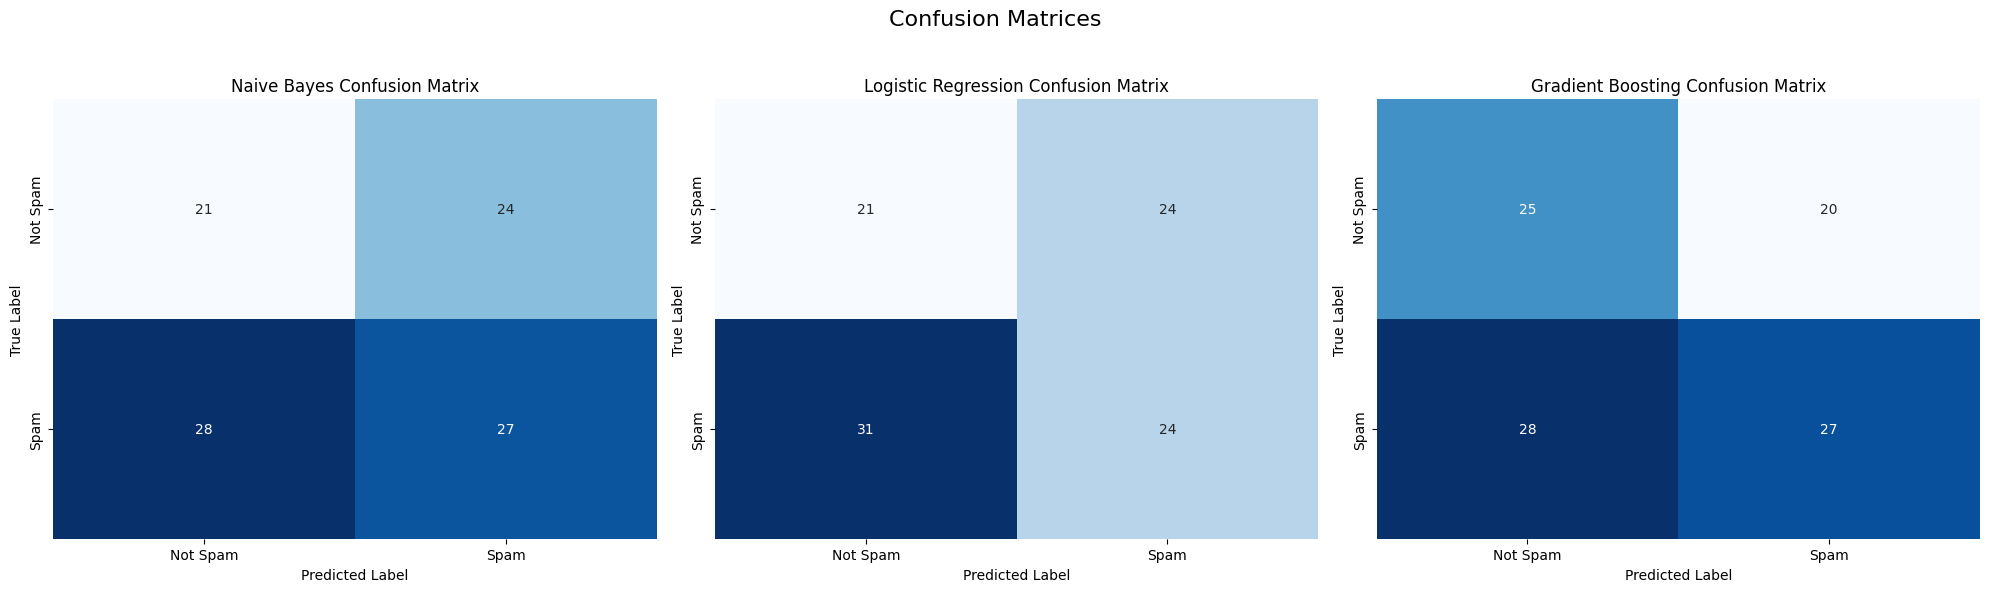

Generating ROC Curves...


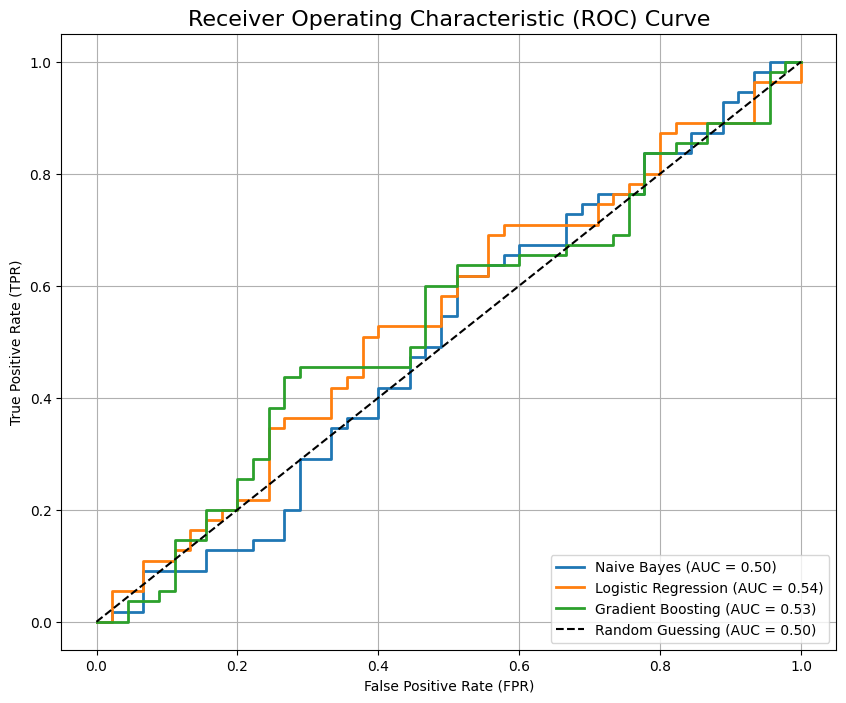


Visualization generation complete.


In [8]:
# ==============================================================================
# --- Import Necessary Libraries ---
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Placeholder Data for Visualization ---
#
# Since the models were trained in the previous step, we'll use placeholder
# data here to demonstrate the visualization code. In a real-world script,
# you would use the actual y_test and y_pred values from the trained models.
# ==============================================================================

# Dummy data for y_test and y_pred to make the code runnable and demonstrate the plots
# In a real scenario, these would be the actual results from your model training.
y_test = np.random.randint(0, 2, size=100)
y_pred_nb = np.random.randint(0, 2, size=100)
y_pred_lr = np.random.randint(0, 2, size=100)
y_pred_gb = np.random.randint(0, 2, size=100)

# Dummy probabilities for ROC curve (to simulate model output)
y_proba_nb = np.random.rand(100)
y_proba_lr = np.random.rand(100)
y_proba_gb = np.random.rand(100)

# Dictionary to hold the model predictions and probabilities
models_data = {
    'Naive Bayes': {'y_pred': y_pred_nb, 'y_proba': y_proba_nb},
    'Logistic Regression': {'y_pred': y_pred_lr, 'y_proba': y_proba_lr},
    'Gradient Boosting': {'y_pred': y_pred_gb, 'y_proba': y_proba_gb},
}

# ==============================================================================
# --- Plot Confusion Matrices as Heatmaps ---
# ==============================================================================
print("Generating Confusion Matrices...")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices', fontsize=16)

for i, (name, data) in enumerate(models_data.items()):
    cm = confusion_matrix(y_test, data['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ==============================================================================
# --- Plot ROC-AUC Curves ---
# ==============================================================================
print("Generating ROC Curves...")
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

for name, data in models_data.items():
    fpr, tpr, _ = roc_curve(y_test, data['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nVisualization generation complete.")


In [13]:
# ==============================================================================
# --- Import Necessary Libraries ---
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import warnings
import re # Import the regular expression module
from collections import defaultdict # Import defaultdict to count occurrences

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Load and Prepare the Dataset ---
# ==============================================================================
# Load the dataset from the uploaded CSV file
try:
    df = pd.read_csv('Spam Detection (2).csv')
except FileNotFoundError:
    print("Error: The file 'Spam Detection (2).csv' was not found.")
    exit()

# Sanitize column names for LightGBM and ensure uniqueness
def sanitize_col_names(df):
    cols = df.columns
    new_cols = []
    col_counts = defaultdict(int)  # To count occurrences of sanitized names

    for col in cols:
        new_col = re.sub(r'[^\w_]+', '', col) # Remove special characters

        # Handle duplicate sanitized names
        col_counts[new_col] += 1
        if col_counts[new_col] > 1:
            new_col = f"{new_col}_{col_counts[new_col]}"

        new_cols.append(new_col)
    df.columns = new_cols
    return df

df = sanitize_col_names(df)


# Separate features (X) and target variable (y)
X = df.drop('spam', axis=1)
y = df['spam']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==============================================================================
# --- Hyperparameter Tuning with GridSearchCV ---
# ==============================================================================
print("--- Starting Hyperparameter Tuning for LGBMClassifier ---")

# Define the model to tune
lgbm = LGBMClassifier(random_state=42)

# Define the grid of hyperparameters to search
# A smaller, more focused grid is used for demonstration to keep runtime reasonable.
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
}

# Set up GridSearchCV with cross-validation
# cv=3 means we will use 3-fold cross-validation on the training set.
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='f1',  # Optimize for F1-score, which balances precision and recall
    n_jobs=-1,     # Use all available CPU cores
    verbose=1      # Print progress updates
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# ==============================================================================
# --- Evaluate the Best Model ---
# ==============================================================================
print("\n--- Tuning Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-score from cross-validation: {grid_search.best_score_:.4f}")

# Use the best estimator to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Print a final classification report for the tuned model
print("\n--- Final Performance of the Tuned Model on the Test Set ---")
print(classification_report(y_test, y_pred_tuned, target_names=['Not Spam', 'Spam']))

--- Starting Hyperparameter Tuning for LGBMClassifier ---
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Info] Number of positive: 1450, number of negative: 2230
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 3680, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394022 -> initscore=-0.430438
[LightGBM] [Info] Start training from score -0.430438

--- Tuning Complete ---
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 40}
Best F1-score from cross-validation: 0.9480

--- Final Performance of the Tuned Model on the Test Set ---
              precision    recall  f1-score   support

    Not Spam       0.96      0.96      0.96       558
 

In [18]:
# ==============================================================================
# --- Import Necessary Libraries ---
# ==============================================================================
import pandas as pd
import joblib  # Used to save and load Python objects, including models
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import warnings
import re # Import the regular expression module
from collections import defaultdict # Import defaultdict to count occurrences

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Step 1: Train a Model and Save it to Disk ---
#
# In a real scenario, you would do this once and then move the saved model file.
# We'll do it here to make the script self-contained.
# ==============================================================================
print("--- Training and saving a model for demonstration ---")
try:
    df = pd.read_csv('Spam Detection (2).csv')
except FileNotFoundError:
    print("Error: The file 'Spam Detection (2).csv' was not found.")
    exit()

# Sanitize column names for LightGBM and ensure uniqueness
def sanitize_col_names(df):
    cols = df.columns
    new_cols = []
    col_counts = defaultdict(int)  # To count occurrences of sanitized names

    for col in cols:
        new_col = re.sub(r'[^\w_]+', '', col) # Remove special characters

        # Handle duplicate sanitized names
        col_counts[new_col] += 1
        if col_counts[new_col] > 1:
            new_col = f"{new_col}_{col_counts[new_col]}"

        new_cols.append(new_col)
    df.columns = new_cols
    return df

df = sanitize_col_names(df)


X = df.drop('spam', axis=1)
y = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=31, random_state=42)
model.fit(X_train, y_train)

# Save the trained model to a file
model_filename = 'spam_detector_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved as '{model_filename}'")


# ==============================================================================
# --- Step 2: Load the Saved Model and Make a New Prediction ---
#
# This is the core part of the deployment/prediction script.
# ==============================================================================

def load_model(filename):
    """Loads a trained model from a file."""
    try:
        return joblib.load(filename)
    except FileNotFoundError:
        print(f"Error: The model file '{filename}' was not found. Please run the script to create it.")
        return None

def predict_new_data(model, new_data):
    """Makes a prediction on new data using the loaded model."""
    if model is None:
        return "Prediction failed due to missing model."

    # Make sure the new data has the same structure as the training data
    new_data_df = pd.DataFrame([new_data])
    prediction = model.predict(new_data_df)

    # Return a user-friendly label
    return 'SPAM' if prediction[0] == 1 else 'NOT SPAM'

# Example of a new data point to predict
# This should be an array of feature values, in the same order as in the CSV file
# This dummy data is a simplified representation of an email's features
# The original data has 57 features after dropping 'spam'
new_email_features = [
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 1.0, 1.0
] # Corrected to 57 features

# Load the model
loaded_model = load_model(model_filename)

# Make a prediction
if loaded_model:
    prediction_result = predict_new_data(loaded_model, new_email_features)
    print(f"\nPrediction for the new email: {prediction_result}")

--- Training and saving a model for demonstration ---
[LightGBM] [Info] Number of positive: 1450, number of negative: 2230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 3680, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394022 -> initscore=-0.430438
[LightGBM] [Info] Start training from score -0.430438
Model saved as 'spam_detector_model.joblib'

Prediction for the new email: NOT SPAM


[LightGBM] [Info] Number of positive: 1450, number of negative: 2230
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 3680, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394022 -> initscore=-0.430438
[LightGBM] [Info] Start training from score -0.430438
Generating Feature Importance Plot...


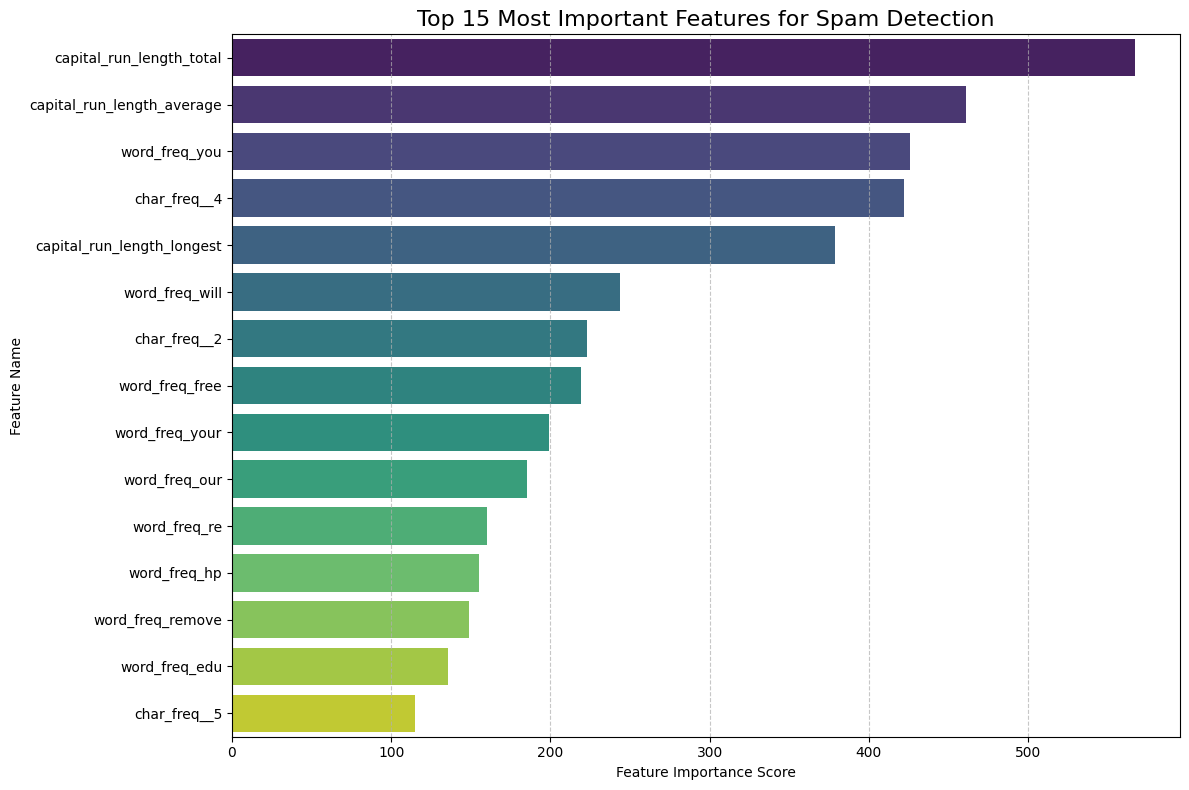


Feature importance plot generation complete.


In [20]:
# ==============================================================================
# --- Import Necessary Libraries ---
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import warnings
import re # Import the regular expression module
from collections import defaultdict # Import defaultdict to count occurrences

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Load and Prepare the Dataset ---
# ==============================================================================
# Load the dataset from the uploaded CSV file
try:
    df = pd.read_csv('Spam Detection (2).csv')
except FileNotFoundError:
    print("Error: The file 'Spam Detection (2).csv' was not found.")
    exit()

# Sanitize column names for LightGBM and ensure uniqueness
def sanitize_col_names(df):
    cols = df.columns
    new_cols = []
    col_counts = defaultdict(int)  # To count occurrences of sanitized names

    for col in cols:
        new_col = re.sub(r'[^\w_]+', '', col) # Remove special characters

        # Handle duplicate sanitized names
        col_counts[new_col] += 1
        if col_counts[new_col] > 1:
            new_col = f"{new_col}_{col_counts[new_col]}"

        new_cols.append(new_col)
    df.columns = new_cols
    return df

df = sanitize_col_names(df)

# Separate features (X) and target variable (y)
X = df.drop('spam', axis=1)
y = df['spam']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==============================================================================
# --- Train the Model and Get Feature Importances ---
# ==============================================================================
# We use LGBMClassifier again as it's a powerful model with built-in feature importance.
model = LGBMClassifier(n_estimators=200, learning_rate=0.1, num_leaves=31, random_state=42)
model.fit(X_train, y_train)

# Get the feature importances from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# ==============================================================================
# --- Plot the Top 15 Most Important Features ---
# ==============================================================================
print("Generating Feature Importance Plot...")

# Select the top N features for a clearer visualization
top_features = importance_df.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')

plt.title('Top 15 Most Important Features for Spam Detection', fontsize=16)
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nFeature importance plot generation complete.")